Modelo predicción de ventas (ARIMA)

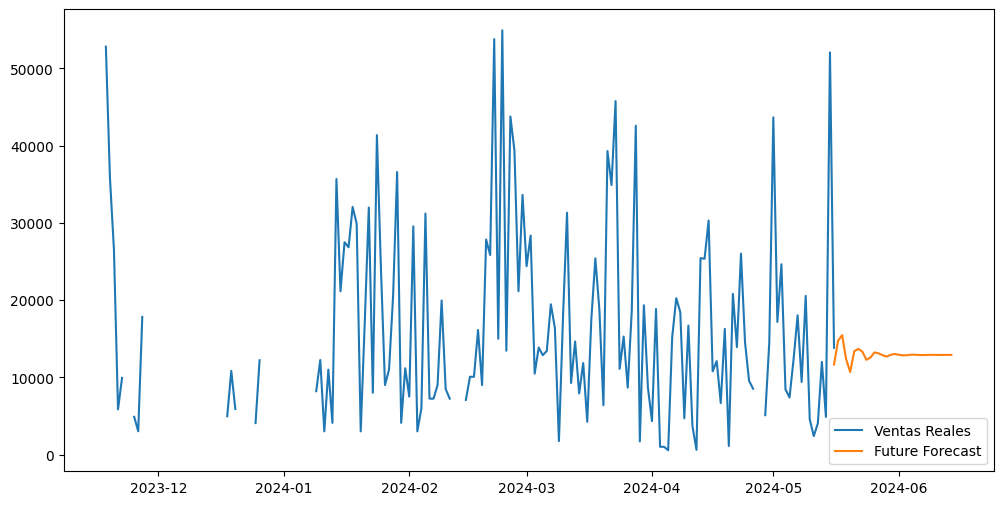

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Cargar los datos
data_path = 'orders.csv'  # Reemplaza esto con la ruta correcta si es necesario
orders_data = pd.read_csv(data_path, encoding='ISO-8859-1')

# Convertir la columna de fecha
orders_data['date_created'] = pd.to_datetime(orders_data['date_created'])

# Agregar las ventas diarias
daily_sales = orders_data.groupby(orders_data['date_created'].dt.date).agg({'total_amount': 'sum'}).reset_index()
daily_sales.columns = ['date', 'total_sales']

# Asegurarse de que la fecha esté en el índice y establecer la frecuencia
daily_sales['date'] = pd.to_datetime(daily_sales['date'])
daily_sales.set_index('date', inplace=True)
daily_sales = daily_sales.asfreq('D')

# Dividir los datos en entrenamiento y prueba
train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]

# Entrenar el modelo ARIMA
model = ARIMA(train['total_sales'], order=(5, 1, 0))  # (p, d, q) son los hiperparámetros de ARIMA
model_fit = model.fit()

# Hacer predicciones después del período de prueba
future_forecast = model_fit.forecast(steps=30)

# Crear una serie de tiempo unificada para las ventas reales
all_sales = pd.concat([train, test])

# Visualizar las predicciones y los datos reales
plt.figure(figsize=(12, 6))
plt.plot(all_sales['total_sales'], label='Ventas Reales')
plt.plot(pd.date_range(start=all_sales.index[-1], periods=30, freq='D'), future_forecast, label='Future Forecast')
plt.legend(loc='best')
plt.show()


Script entrenamiento para SageMaker

In [ ]:
# sagemaker_arima.py

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import joblib

def train(data_path, model_path):
    # Cargar los datos
    orders_data = pd.read_csv(data_path, encoding='ISO-8859-1')
    orders_data['date_created'] = pd.to_datetime(orders_data['date_created'])
    
    # Agregar las ventas diarias
    daily_sales = orders_data.groupby(orders_data['date_created'].dt.date).agg({'total_amount': 'sum'}).reset_index()
    daily_sales.columns = ['date', 'total_sales']
    
    # Asegurarse de que la fecha esté en el índice y establecer la frecuencia
    daily_sales['date'] = pd.to_datetime(daily_sales['date'])
    daily_sales.set_index('date', inplace=True)
    daily_sales = daily_sales.asfreq('D')

    # Dividir los datos en entrenamiento y prueba
    train_size = int(len(daily_sales) * 0.8)
    train, test = daily_sales[:train_size], daily_sales[train_size:]

    # Entrenar el modelo ARIMA
    model = ARIMA(train['total_sales'], order=(5, 1, 0))
    model_fit = model.fit()

    # Guardar el modelo
    joblib.dump(model_fit, f"{model_path}/arima_model.pkl")

if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--data-path', type=str, required=True)
    parser.add_argument('--model-path', type=str, required=True)
    args = parser.parse_args()
    train(args.data_path, args.model_path)



Script de Integración con el Dashboard

In [ ]:
import boto3
import pandas as pd
import joblib

def load_model_from_s3(bucket_name, model_path):
    s3_client = boto3.client('s3')
    model_file = f"/tmp/arima_model.pkl"
    s3_client.download_file(bucket_name, model_path, model_file)
    model = joblib.load(model_file)
    return model

def predict_sales(model, steps=30):
    forecast = model.forecast(steps=steps)
    return forecast

# Parámetros para S3
bucket_name = 'your-bucket-name'  # Reemplaza con el nombre de tu bucket de S3
model_path = 'path/to/s3/model/arima_model.pkl'  # Reemplaza con la ruta a tu modelo en S3

# Cargar el modelo desde S3
model = load_model_from_s3(bucket_name, model_path)

# Hacer predicciones de ventas para los próximos 30 días
future_forecast = predict_sales(model, steps=30)

# Unir las predicciones con las fechas correspondientes
last_date = pd.to_datetime('2024-05-10')  # Reemplaza con la última fecha de tu dataset
forecast_dates = pd.date_range(start=last_date, periods=30, freq='D')
forecast_df = pd.DataFrame({'date': forecast_dates, 'forecast': future_forecast})

print(forecast_df)

Invocar el Modelo desde el Dashboard

In [ ]:
import boto3
import pandas as pd
import joblib
import json

def invoke_sagemaker_endpoint(endpoint_name, data):
    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/json',
        Body=json.dumps(data)
    )
    result = response['Body'].read().decode('utf-8')
    return pd.read_json(result)

# Crear datos de ejemplo
# Aquí puedes enviar los datos reales que quieres predecir
sample_data = {
    "date": ["2024-05-10"],  # Reemplaza con la última fecha de tu dataset
}

# Nombre del endpoint en SageMaker
endpoint_name = 'your-sagemaker-endpoint'  # Reemplaza con el nombre de tu endpoint en SageMaker

# Invocar el endpoint de SageMaker
predictions = invoke_sagemaker_endpoint(endpoint_name, sample_data)
print(predictions)